# Subject

All clients have to be visited one time. A client can be served more than one time but it is not optimal knowing that triangular inequality is valid in this problem. The routes visiting the clients are done by bikes. A bike can serve all the clients in a circular area. The route of a bike starts from its depot and finish at its depot. There are many depots. A subset of the depots may be selected to covers all the clients. The truck need to visit all the selected depots. The route of the truck start from the "center" and finish at the "center".

# TODO
1. Determine the minimum number of depots so that each client is at a maximum distance of D from a depot. Use the coverage problem as a guide for this problem.
2. A truck feeds the depots from the center at point (0,0). What is the route with minimal distance for the truck ? For this question we will not question the selection of the depots made in 1). Use the TSP problem for this problem.
3. For each depot a bike courier delivers customers. What are the routes with minimal distance for the couriers ?
4. Let's go back to 1) and 2) How can we jointly optimize the selection of the depots and the cost of the truck route ?
5. Let's go back to 1), 2) and 3). How to jointly optimize the selection of depots, the cost of all routes (truck and bikes)

In [123]:
import json
import random
import pandas as pd
from pulp import *

# Classe Instance

In [124]:
class Point:
    """un point sur une grille 100x100 """#

    def __init__(self, x=0, y=0, rand = False):
        """ si rand=True alors on genere un point aleatoire sur une grille 100x100
            """
        if rand : 
            self.x = random.randint(-50,50)
            self.y = random.randint(-50,50)
        else:
            self.x = x
            self.y = y
    
    def __str__(self):
        """ fonction qui est appellée si on fait str(Point()) ou print(Point())
            """
        return f"P({self.x},{self.y})"
    
    def __repr__(self):
        """ fonction qui est appellée si on fait str([Point(),...]) ou print([Point(),...])
            """
        return str(self)
    
    def get_tuple(self):
        """ retourne les coordonées
            """
        return (self.x,self.y)
        

In [125]:
class Instance :
    """instance of the problem"""#
    
    def __init__(self, clients=[], depots=[], maxDist = 30, nbCover = 1):
        """constructor of Instance"""
        
        self.maxDist = maxDist  
        """it is the diameter of covering for each depots"""
        
        self.nbCover = nbCover
        """the covering rate : e.g. if nbCover = 2 then each point is covered by at least two depots
            it is used in the random generation of the instance
            and it is kept as a caracteristic of the instance
            """
        
        self.clients = clients      
        """the list of client that need to be served
            it is a dictionary {i: p} with i the id of the point and p the point
            """
        
        self.depots = depots 
        """ the list of all possible depots
            it is a dictionary {i: p} with i the id of the point and p the point
            """
        
        self.center = Point(0,0) 
        """ the origin of the truck (e.g. factory, wharehouse) 
            at the center of the map 
            """ 
        
    def get_id_center(self):
        """ retourne l'id du centre
            """
        return len(self.clients) + len(self.depots)
        
    def get_point_from_id(self, idPoint):
        """return the Point object from id in points or depots
            the id are ordered as follows :
            
            [0, ... , nbClient-1] + [nbClient, ... , nbClient+nbDepots-1] + [nbClient+nbDepots]
                     |                                |                             |
                 the clients                     the depots                     the center
            """
        #if the id is the center
        if idPoint == self.get_id_center() :
            return self.center
        
        #if the id is a depot 
        if idPoint >= len(self.clients):
            return self.depots[idPoint]
        
        #if the id is a client
        return self.clients[idPoint]
        
    def dist(self, p1, p2):
        """ @return euclidian distance from @p1 to @p2
            the returned value is an int
            this norm respects the triangular inequality
            The accepted types are 
            - int : the ids of the points
            - Point : the points directly
            """
        #if p1 or p2 are not Points but int
        if isinstance(p1, int):
            p1 = self.get_point_from_id(p1)
        if isinstance(p2, int):
            p2 = self.get_point_from_id(p2)
        
        #return the distance
        return int(((p1.x - p2.x)**2 + (p1.y - p2.y)**2)**0.5)
            
    def genRandom(self, nbClients = 100, nbDepots = 25):
        """ generate a random instance
            @nbClients : number of generated clients
            @nbDepot : number of generated depots
            """
        self.nbClients = nbClients
        self.nbDepots = nbDepots
        
        #the mecanism while/break ensure that all clients are covered @self.nbCover times
        i=0
        while(True):
            print(i,end="\r")
            
            #depots are generated
            self.depots = {d: Point(rand=True) for d in range(nbClients,nbClients + nbDepots)}
            
            #clients are generated
            self.clients = {p: self.gen_covered_point() for p in range(nbClients)}
            
            #check that all clients are covered @self.nbCover times 
            if self.is_all_covered(): 
                #if true : the instance is kept
                break
            #if not : the instance is re-generated
            i += 1
            
    def gen_covered_point(self):
        """generates and @return a covered point
            this method try 1000 times to generate a point covered at least @self.nbCover times
            """
        for _ in range(1000):
            p = Point(rand=True)
            if len(self.get_list_covering_depots(p, self.depots)) >= self.nbCover:
                return p
        return p
            
    def is_all_covered(self):
        """ test if all clients are covered by nbCover depots 
            with a distance lower than distMax
            """
        for p in self.clients:
            if len(self.get_list_covering_depots(p, self.depots)) < self.nbCover:
                return False
        return True
    
    def get_list_covering_depots(self, p, depots):
        """ @return the sublist of @depots that covers point @p
            """ 
        covered_depots = []
        for d in depots:
            if self.dist(p,d) <= self.maxDist:
                covered_depots.append(d)
        return covered_depots

    def get_list_covered_clients(self, d, clients):
        """ @return the sublist of @clients covered by depot @d
            """ 
        covered_clients = []
        for p in clients:
            if self.dist(p,d) <= self.maxDist:
                covered_clients.append(p)
        return covered_clients
    
    def get_xy_from_listPointId(self, listPointId):
        """ @return (x,y) two lists of coordinates for the list of point @listPointId
            it is usefull to display/plot the points
            """
        x = [self.get_point_from_id(idP).x for idP in listPointId]
        y = [self.get_point_from_id(idP).y for idP in listPointId]
        return x,y
    
    def get_plot(self, circle = True, ids=True, depots = None):
        """display the instance on a grid
            @ids : if true a text with the id is diplayed
            @circle : if true the circles are diplayed
            @depots : an alternative list of depots is possible, usefull to display the selected depots only
                      if depots is not specified the list @self.depots is displayed in red
            """
        
        #if depot is not specified the default list is self.depots
        if depots == None :
            depots = self.depots
        
        #the plot is created
        import matplotlib.pyplot as plt
        
        #clients are displayed in green
        x,y = self.get_xy_from_listPointId(self.clients)
        plt.scatter(x, y, color="green")
        if ids:
            for i,p in self.clients.items():
                plt.annotate(str(i), xy=p.get_tuple()) 
        
        #depots are displayed in gray
        x,y = self.get_xy_from_listPointId(self.depots)
        plt.scatter(x, y, color="lightgray")
        
        #if a depot is in the list @depot then it is displayed in red (by default all depots are in red)
        x,y = self.get_xy_from_listPointId(depots)
        plt.scatter(x, y, color="red")
        if ids:
            for i in depots:
                plt.annotate(str(i), xy=self.get_point_from_id(i).get_tuple()) 
        
        #if @circle is true the circles are displayed
        if circle:
            for xp, yp in zip(x,y):
                draw_circle = plt.Circle((xp, yp), self.maxDist ,fill=False)
                plt.gcf().gca().add_artist(draw_circle)
        
        #the center is diplayed in blue
        x,y = self.get_xy_from_listPointId([self.get_id_center()])
        plt.scatter(x, y, color="blue")
        if ids:
            plt.annotate(str(self.get_id_center()), xy=self.center.get_tuple())

        # set the axes and the title of the plot        
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Instance')
        
        return plt
    
    def plot(self, circle = True, ids=True) :
        """this method shows the plot by calling the show() method
            """
        self.get_plot(circle, ids).show()
        
    def to_json(self, fileName = ""):
        """export the instance to json format
            if @fileName is specified the json file is written
            @return a dictionnay formated as json object
            """ 
        #generate a dictionnay formated as json object
        jsonObj = {"clients": {i:p.get_tuple() for i,p in self.clients.items()},
                   "depots": {i:d.get_tuple() for i,d in self.depots.items()},
                   "maxDist": self.maxDist,
                   "nbCover": self.nbCover,
                  }
        
        #if @fileName is specified the json file is written
        if fileName != "":
            with open(fileName, 'w') as outfile:
                json.dump(jsonObj, outfile, indent=2)
        
        #return a dictionnay formated as json object
        return jsonObj
        
    def from_json(self, jsonFileName, jsonObj = None):
        """loads the instance from json file @jsonFileName
            if @jsonObj is specified the file is not read and @jsonObj is loaded instead
            """
        
        #if @jsonObj is not specified the file @jsonFileName is read
        if jsonObj == None:
            with open(jsonFileName) as json_file:
                jsonObj = json.load(json_file)
        self.clients = {int(i) : Point(p[0],p[1]) for i,p in jsonObj['clients'].items()}
        self.depots = {int(i) : Point(p[0],p[1]) for i,p in jsonObj['depots'].items()}
        self.maxDist = jsonObj['maxDist']
        self.nbCover = jsonObj['nbCover']
        
    def __str__(self):
        """ method called by function str() or print() on objects Instance
            """
        return json.dumps(self.to_json(),indent=2)

# Classe Solution

In [126]:
class Solution:
    
    def __init__(self,instance):
        """initialize an empty solution
            @instance : the instance considered
            """
        
        self.instance = instance
        """the instance solved"""
        
        self.selected_depots = []
        """the liste of id for the selected depots"""
        
        self.truck_route = []
        """the list of id for the route of the truck
            starting and finishing by the id of the center point
            [id_center, depot_i, depot_j, depot_k, .... , id_center] 
            """
        
        self.bikes_routes = []
        """the list routes visiting the clients
            one route per bike, one bike per depot
            [
            [id_depot_i, client_i, client_j, ... , id_depot_i] <- route 1
            [id_depot_j, client_k, ...           , id_depot_j] <- route 2
               ...
            [ ...                                            ] <- route N
            ]
            with N the number of selected depots
            """
        
        self.truck_cost = -1
        """ the cost of the truck route"""
        
        self.bikes_costs = []
        """ the list of costs of each bike route"""
        
        self.cost = -1
        """ cost of the solution """
        
    def check(self):
        """check if all constraints are satisfied
            """
        
        #Check if all clients are covered by selected depots
        print("Check if all clients are covered by selected depots")
        not_covered = []
        for p in self.instance.clients:
            if len(self.instance.get_list_covering_depots(p, self.selected_depots)) < 1:
                not_covered.append(p)
        if len(not_covered)>0 : 
            print("    -> clients", not_covered, "not covered")
        else :
            print("    -> each point covered : ok")
            
        #Check if route of the truck serves all selected depots
        print("Check if route of the truck serves all selected depots")
        not_served = []
        for d in self.selected_depots:
            if d not in self.truck_route:
                not_served.append(d)
        if len(not_served)>0 : 
            print("    -> depots", not_served, "not served by the route")
        else :
            print("    -> each depot served by the truck : ok")
            
        #Check if there is one route per bike
        print("Check if there is one route per bike")
        test = True
        for d in self.selected_depots :
            if d not in [rout[0] for rout in self.bikes_routes]:
                print("    -> route for depot", d, "not created")
                test = False
        if test :
            print("    -> each depot has route : ok")
        
        #Check if each clients is served one time
        print("Check if each clients is served one time")
        clients_not_served = []
        clients_served_many_times = []
        for p in self.instance.clients:
            served = 0
            for rout in self.bikes_routes :
                for p2 in rout:
                    if p == p2 :
                        served += 1
            if served < 1:
                clients_not_served.append(p)
            elif served > 1:
                clients_served_many_times.append(p)
                
        if len(clients_not_served) > 0 : 
            print("    -> clients", clients_not_served, "not served by a bike route")
        
        if len(clients_served_many_times) > 0 : 
            print("    -> clients", clients_served_many_times, "served more than one time by bike routes")
        
        if len(clients_served_many_times) == 0 and len(clients_not_served) == 0 : 
            print("    -> each point served one time by a bike : ok")
    
    def get_closest_point(self, p, list_points):
        """ @return the closest point of @list_points from @p
            """
        closest = list_points[0]
        for p2 in list_points:
            if self.instance.dist(p, p2) < self.instance.dist(p, closest):
                closest = p2
        return closest
    
    def select_depots_naively(self):
        """ select a subset of self.instance.depots
            for each point not covered the closest depot is selected
            """
        self.selected_depots = []
        allDepots = self.instance.depots
        
        def commun_item(iterableA, iterableB):
            """ @return true if one item of @iterableA is in @iterableB
                This function is declared in the method Solution.select_depots_naively()
                python is very permissive...
                """
            for it in iterableA:
                if it in iterableB:
                    return True
            return False
        
        for p in self.instance.clients:
            covering_depots = self.instance.get_list_covering_depots(p,allDepots)
            if not commun_item(covering_depots, self.selected_depots):
                closest_depot = self.get_closest_point(p, covering_depots)
                self.selected_depots.append(closest_depot)
        
    def set_truck_route_naively(self):
        """ create a route by serving the closest depot not served
            """
        depots_not_served = list(self.selected_depots)
        last_depot = self.instance.get_id_center()
        self.truck_route = [last_depot]
        while len(depots_not_served) > 0 :
            closest_depot = self.get_closest_point(last_depot, depots_not_served)
            self.truck_route.append(closest_depot)
            depots_not_served.remove(closest_depot)
            last_depot = closest_depot
        self.truck_route.append(self.instance.get_id_center())
        
    def set_bike_routes_naively(self):
        """ create bikes routes by serving 
            the closest point not served and covered
            """
        self.bikes_routes=[[] for d in self.selected_depots]
        for i,d in enumerate(self.selected_depots):
            
            clients_not_served = self.instance.get_list_covered_clients(d, self.instance.clients)
            
            #remove clients already served by an other route
            for p in self.instance.get_list_covered_clients(d, self.instance.clients):
                for rout2 in self.bikes_routes:
                    for p2 in rout2:
                        if p == p2:
                            clients_not_served.remove(p)
            
            #create route by serving the closest point not served
            last_point = d
            self.bikes_routes[i].append(d)
            while len(clients_not_served) > 0 :
                closest_point = self.get_closest_point(last_point, clients_not_served)
                self.bikes_routes[i].append(closest_point)
                clients_not_served.remove(closest_point)
                last_point = closest_point
            self.bikes_routes[i].append(d)
                
    def set_truck_cost(self):
        """set the cost of the truck route
            @return the cost of the truck route
            """
        self.truck_cost= 0
        for p in range(len(self.truck_route)-1):
            self.truck_cost += self.instance.dist(self.truck_route[p],self.truck_route[p+1])
        return self.truck_cost
    
    def set_bikes_costs(self):
        """set the costs of the bikes routes
            @return the cost of bikes routes
            """
        self.bikes_costs = [0 for _ in self.selected_depots]
        for i,d in enumerate(self.selected_depots): 
            rout = self.bikes_routes[i]
            for p in range(len(rout)-1):
                self.bikes_costs[i] += self.instance.dist(rout[p],rout[p+1])
        return self.bikes_costs
    
    def set_all_cost(self):
        """set the cost of the solution
            set the cost of all routes
            @return the total cost
            """
        self.cost = self.set_truck_cost() + sum(cost for cost in self.set_bikes_costs())
        return self.cost
    
    def set_all_naively(self):
        """create naive solution
            """
        self.select_depots_naively()
        self.set_truck_route_naively()
        self.set_bike_routes_naively()
        return self.set_all_cost()

    def plot(self, circle = True, routes = True, ids = True):
        """display the solution on a grid"""
        
        plt = self.instance.get_plot(circle = circle, ids = ids, depots = self.selected_depots)
        
        if routes:
            import numpy as np

            x,y = self.instance.get_xy_from_listPointId(self.truck_route)
            plt.plot(x, y, color = "red", linestyle='dashed', linewidth=2)
            
            for rout in self.bikes_routes:
                x,y = self.instance.get_xy_from_listPointId(rout)
                col = (np.random.random(), np.random.random(), np.random.random())
                plt.plot(x, y, color = col, linestyle='dashed', linewidth=2)
                
        plt.title('Solution')
        plt.show() 
        
    def to_json(self, fileName = ""):
        """export the solution to json format
            """
        jsonObj = {"inst":            self.instance.to_json(),
                   "selected_depots": self.selected_depots,
                   "truck_route":     self.truck_route,
                   "bikes_routes":    [rout for rout in self.bikes_routes],
                  }
        if fileName != "":
            with open(fileName, 'w') as outfile:
                json.dump(jsonObj, outfile, indent=2)
        return jsonObj
        
    def from_json(self, jsonFileName):
        """load the solution from json format
            """
        with open(jsonFileName) as json_file:
            jsonObj = json.load(json_file)
        self.instance = Instance()
        self.instance.from_json("", jsonObj = jsonObj["inst"])
        self.selected_depots = jsonObj['selected_depots']
        self.truck_route     = jsonObj['truck_route']
        self.bikes_routes    = jsonObj['bikes_routes']
        
    def __str__(self):
        """ str() or print() """
        return json.dumps(self.to_json(),indent=2)
    
    def solve_depot_selection(self):
        prob = LpProblem("Minimiser_nbr_depots", LpMinimize)
        x = LpVariable.dicts("depot", self.instance.depots.keys(), 0, 1, LpBinary)

        # Objectif : Minimiser le nombre de dépôts sélectionnés
        prob += lpSum([x[d] for d in self.instance.depots.keys()])

        # Contrainte : Chaque client doit être couvert par au moins un dépôt
        """Cette contrainte est intrinsèquement vérifiée grâce à l'utilisation de la méthode `inst.get_list_covering_depots(client, inst.depots)`. 
        Cette méthode renvoie une liste de dépôts qui sont à une distance maximale `inst.maxDist` de chaque client. """
        for client in self.instance.clients:
            prob += lpSum(x[d] for d in self.instance.get_list_covering_depots(client, self.instance.depots)) >= 1, f"couverture_client_{client}"

        # Résoudre le problème
        prob.solve(GUROBI(timeLimit=120))

        # Mettre à jour les dépôts sélectionnés basés sur la solution
        self.selected_depots = [d for d in self.instance.depots.keys() if x[d].value() == 1]

    def solve_truck_route(self):
        prob = LpProblem("Minimiser_trajet_camion", LpMinimize)
        
        # Initialisation des points à visiter : dépôts sélectionnés + point de départ qui est l'usine située au centre
        points = self.selected_depots + [self.instance.get_id_center()] # Cette liste représente donc tout les points que le camion doit visiter
        
        # Variables de décision binaire pour les trajets entre chaque paire de points à visiter
        x = LpVariable.dicts("route", [(i, j) for i in points for j in points if i != j], 0, 1, LpBinary)

        # Variables de décision séquentielle pour l'ordre de visite des points
        position = LpVariable.dicts("position", points, 0, len(points) - 1, cat='Continuous')

        # Objectif : minimiser la distance totale parcourue
        prob += lpSum([self.instance.dist(i, j) * x[(i, j)] for i in points for j in points if i != j])

        # Contraintes de visite unique pour chaque point
           
        """ Ici le but est de s'assurer que pour chaque point, il y'a exactement un trajet en camion qui arrive
                et un trajet camion qui part, ce qui garanti alors que chaque point (et donc chaque depot)
                est visité exactement et uniqueement une fois par le camion """
            
        for point in points:
            prob += lpSum([x[(i, point)] for i in points if i != point]) == 1, f"arrivee_{point}"
            prob += lpSum([x[(point, j)] for j in points if j != point]) == 1, f"depart_{point}"

        # Contrainte d'élimination des sous-tours
        
        """ Ici le but est de s'assurer qu'il n'y a pas de formation de sous-tours, et donc 
                un tour doit contenir tout les points à visiter, soit tous les points de la liste points,
                si un point part d'un depot i vers un depot j, la variable séquentielle de j (position[j]), 
                doit être supérieure à celle de i (position[i], sauf si j (ou i) represente l'usine !!!)   """
            
        M = len(points)
        for i in points:
            for j in points:
                if i != j and (i != self.instance.get_id_center() and j != self.instance.get_id_center()):
                    prob += position[i] - position[j] + M*x[(i, j)] <= M-1  # M est un terme qui n'affecte la contrainte que si le camion va directement de i à j (x[(i, j)] = 1). Dans ce cas, il force la différenc de position à être inférieure à len(depots_selectionnes)-1, assurant l'ordre correct dans l'itinéraire.
        

        # Résolution du problème      (on limite le temps de résololution à 2 min pour les grandes instances (6 et 7))
        prob.solve(GUROBI(timeLimit=120))

        # Initialisation de l'itinéraire du camion avec le point de départ étant le centre de distribution
        self.truck_route = [self.instance.get_id_center()]

        # Tant que l'itinéraire du camion ne contient pas tous les points à visiter
        while len(self.truck_route) < len(points):
            # Identification du dernier point visité dans l'itinéraire actuel
            last_point = self.truck_route[-1]

            # Recherche des points suivants possibles à visiter depuis le dernier point visité
            # Cela est déterminé par la solution, (où x[(i, j)] == 1) indique un trajet choisi du point i au point j
            next_points = [j for (i, j) in x if i == last_point and value(x[(i, j)]) == 1]   # value(x[(i,j)] représente la valeur optimale de la variable de décision x)

            # Si un ou plusieurs points suivants sont trouvés, le premier est ajouté à l'itinéraire
            if next_points: # Si la liste n'est pas vide
                self.truck_route.append(next_points[0])
            else:
                # En cas d'absence de point suivant, on arrête la boucle pour éviter une boucle infinie
                break

        # Une fois tous les points visités, si le dernier point de l'itinéraire n'est pas l'usine
        # on ajoute l'usine à l'itinéraire pour assurer le retour du camion à l'usine (situé au centre)
        if self.truck_route[-1] != self.instance.get_id_center():
            self.truck_route.append(self.instance.get_id_center())
        
    def solve_bike_route(self):      # même logique pour l'itinéraire des camions

        # Réinitialisation des itinéraires des vélos
        self.bikes_routes = [[] for _ in self.selected_depots] # crée une liste vide pour chaque depot selectionne

        # Ensemble des points (clients + dépôts sélectionnés)
        all_points = list(self.instance.clients.keys()) + self.selected_depots # Cette liste représente tout les points que le coursier devra visité
        clients = list(self.instance.clients.keys())
        
        prob = LpProblem("Minimiser_trajet_Coursiers", LpMinimize)

        # Variables de décision pour les trajets
        x = LpVariable.dicts("route", [(i, j) for i in all_points for j in all_points if i != j], cat='Binary')
        u = LpVariable.dicts("position", clients, 0, len(clients)-1, cat='Continuous')

        # Objectif
        prob += lpSum([self.instance.dist(i, j) * x[(i, j)] for i in all_points for j in all_points if i != j])

        # Contraintes de visite unique
                
        """ Ici, comme pour le truck, le but est de s'assurer que pour chaque point, il y'a exactement
            un trajet en vélo qui arrive et un trajet vélo qui part, ce qui garanti alors que chaque 
            point (et donc chaque client) est visité exactement et uniqueement une fois par le coursier en vélo """
            
        for j in clients:
            prob += lpSum(x[(i, j)] for i in all_points if i != j) == 1
            prob += lpSum(x[(j, i)] for i in all_points if i != j) == 1
        
        
        # Élimination des sous-tours
        
        """ Ici, toujours comme pour le truck, le but est de s'assurer qu'il n'y a pas de formation
            de sous-tours, et donc un tour doit contenir tout les points à visiter, soit tous les points 
            de la liste clients, si un point part d'un client i vers un client j, la variable séquentielle 
            de j (u[j]), doit être supérieure à celle de i (u[i], sauf si j (ou i) represente le dépôt de départ !!!)   """
        
        for i in clients:
            for j in clients:
                if i != j:
                    prob += u[i] - u[j] + len(clients) * x[(i, j)] <= len(clients)-1
                    
        # Chaque itinéraire commence et se termine au dépôt correspondant
        
        """ Ici, le but est de s'assurer que chaque itinéraire de vélo commence et se termine avec un depot
            correspondant
                                                                                                                """
        for depot_corres in self.selected_depots:
            # Chaque dépôt envoie un vélo à exactement un client
            prob += lpSum(x[(depot_corres, j)] for j in clients) == 1
            # Chaque itinéraire revient au dépôt après avoir visité les clients
            prob += lpSum(x[(i, depot_corres)] for i in clients) == 1 
        

        # Résoudre le problème
        prob.solve(GUROBI(timeLimit=120))
        
        """" Ici la logique de la construction des itinéraires de vélo et la suivante :
                On initialise un ensemble global pour suivre tous les clients déjà visités.
                Pour chaque dépôt, on crée un itinéraire en partant du dépôt, en visitant les clients
                non encore visités, et en retournant au dépôt, basé sur les trajets déterminés comme optimaux
                par la solution du problème avec la fonction value().
                Pour chaque itinéraire, on cherche le prochain point à visiter qui n'a pas encore été visité 
                et qui est accessible depuis le point actuel selon la solution. Si un tel point est trouvé, 
                il est ajouté à l'itinéraire du vélo. Ce processus se répète jusqu'à ce qu'il n'y ait plus de 
                clients non visités accessibles.
                Chaque itinéraire de vélo est complété en assurant son retour au dépôt initial."""
            
        # Mise à jour des itinéraires des vélos
        # Initialisation d'un ensemble pour suivre les clients déjà visités par n'importe quel itinéraire de vélo
        visited_clients_global = []

        # On parcourt chaque dépôt sélectionné pour construire un itinéraire de vélo pour chaque dépôt
        for depot_index, depot in enumerate(self.selected_depots): # fournit à la fois l'indice et la valeur
            # Le point de départ de l'itinéraire est le dépôt lui-même
            current_point = depot
            # On initialise l'itinéraire du vélo avec le dépôt de départ
            bike_route = [depot]

            # On continue à chercher des clients à visiter jusqu'à ce que tous les clients soient visités
            while True:
                # Recherche du prochain client à visiter qui n'a pas encore été visité
                next_point = None
                for j in all_points:
                    # Si un trajet est choisi du point actuel *current_point* au point *j*, et que *j* n'a pas encore été visité, alors *j* est notre prochain point.
                    if j != current_point and x[(current_point, j)].value() == 1 and j not in visited_clients_global:
                        next_point = j
                        break

                # Si aucun point suivant n'est trouvé, cela signifie que soit tous les clients ont été visités,soit il n'y a pas de chemin possible vers un autre client non visité
                if next_point is None:
                    break  # On sort de la boucle while

                # On ajoute le prochain point à l'itinéraire du vélo
                bike_route.append(next_point)
                # Si ce point est un client, on l'ajoute à l'ensemble des clients déjà visités
                if next_point in clients:
                    visited_clients_global.append(next_point)

                # On met à jour le point actuel pour continuer la construction de l'itinéraire à partir de ce nouveau point
                current_point = next_point

            # Une fois que l'itinéraire est complet, on assure le retour au dépôt de départ
            bike_route.append(depot)
            # On assigne l'itinéraire construit à l'itinéraire correspondant du vélo dans la liste des itinéraires des vélos
            self.bikes_routes[depot_index] = bike_route

    


# Subject

- All clients have to be visited one time. A client can be served more than one time but it is not optimal knowing that triangular inequality is valid in this problem.
- The routes visiting the clients are done by bikes. A bike can serve all the clients in a circular area. 
- The route of a bike starts from its depot and finish at its depot.
- There are many depots. Only a subset of the depots can be selected to covers all the clients. 
- The truck need to visit all the selected depots. The route of the truck start from the "center" and finish at the "center".  

1) Determine the minimum number of depots so that each client is at a maximum distance of $\bar{D}$ from a depot. Use the coverage problem as a guide for this problem.
2) A truck feeds the depots from a center (at point (0,0)). What is the minimum distance route the truck must take ? For this question we will not question the selection of the depots made in 1). Use the TSP problem for this problem.
3) For each depot a bike courier delivers the customers. What routes should the couriers take to minimize the travel cost?
4) Let's go back to 1) and 2). How can we jointly optimize the selection of the depots and the cost of the truck route?
5) Let's go back to 1), 2) and 3). How to jointly optimize the selection of depots, the cost of all routes (truck and bikes). 



In [127]:
def solve_naive (inst_name, verbose= False, plotandcheck = False):
    inst = Instance()
    inst.from_json(inst_name)
    inst.plot()

    sol=Solution(instance=inst)
    sol.set_all_naively()

    sol.check()
    sol.plot(circle = False, routes = True, ids = True)
    print(sol.cost)
    

In [128]:
def solve_optimal(inst_name, verbose=False, plotandcheck=False):

    inst = Instance()
    inst.from_json(inst_name)
    inst.plot()

    # Initialisation de la solution
    sol = Solution(instance=inst)

    # Résolution du problème de sélection des dépôts
    sol.solve_depot_selection()

    # Résolution du problème de l'itinéraire du camion
    sol.solve_truck_route()
    
    # Résolution du problème de routage des vélos
    sol.solve_bike_route()
    
    # Calcul du coût total de la solution
    sol.cost = sol.set_all_cost()
    sol.check()
    sol.plot(circle = False, routes = True, ids = True)
    print(sol.cost)



In [135]:
inst_names = [
    "inst_01_01.json",
    "inst_05_03.json",
    "inst_10_05.json",
    "inst_20_15.json",
    "inst_30_20.json",
    "inst_50_25.json",
    "inst_100_30.json",
    "inst_200_30.json",
    "inst_new_30_15_30.json",
    "inst_new_40_15_20.json",
    "inst_new_80_20_30.json",
    "inst_new_200_40_30.json",
    
]

## Solution naïve : 

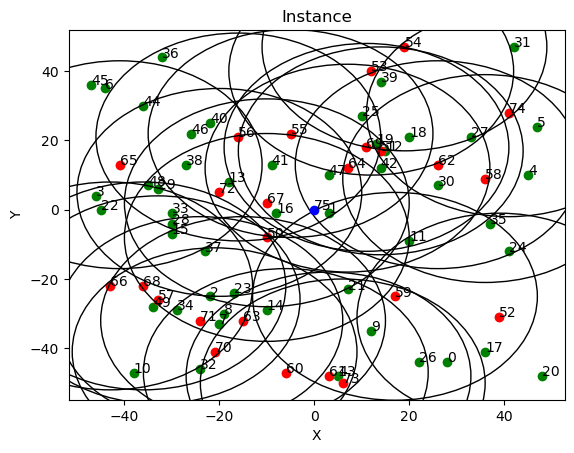

Check if all clients are covered by selected depots
    -> each point covered : ok
Check if route of the truck serves all selected depots
    -> each depot served by the truck : ok
Check if there is one route per bike
    -> each depot has route : ok
Check if each clients is served one time
    -> each point served one time by a bike : ok


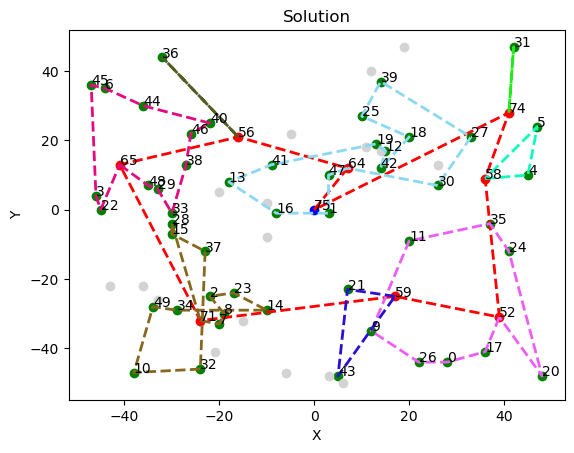

1063


In [133]:
solve_naive(inst_names[5])

## Notre proposition de solution optimisée : 

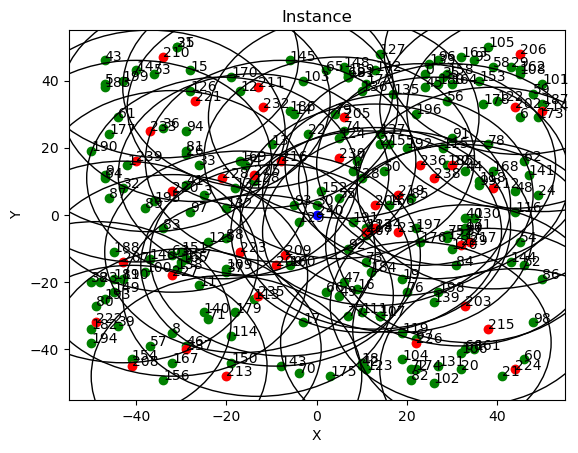

Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: AMD Ryzen 7 6800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 200 rows, 40 columns and 1789 nonzeros
Model fingerprint: 0xae6b7c5b
Variable types: 0 continuous, 40 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 8.0000000
Presolve removed 185 rows and 25 columns
Presolve time: 0.00s
Presolved: 15 rows, 15 columns, 49 nonzeros
Found heuristic solution: objective 7.0000000
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: cutoff, 11 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  O

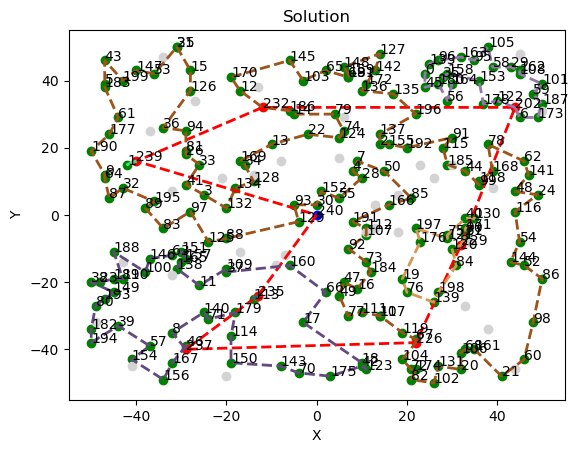

1328


In [138]:
solve_optimal(inst_names[11])

In [99]:
inst = Instance()
inst.from_json(inst_names[2])

# Question 1 : Nombre de dépôts minimale

## Variable de décision : 

Pour chaque dépôt d, $x_d$ est une variable de décision binaire qui peut prendre l'une des deux valeurs suivantes :

- $x_d$ = 1 : signifie que le dépôt d est sélectionné.
- $x_d$ = 0 : signifie que le dépôt d n'est pas sélectionné.

In [100]:
x = LpVariable.dicts("depot", inst.depots.keys(), 0, 1, LpBinary)
print(x)
print("nb de variables x =", len(x))

{10: depot_10, 11: depot_11, 12: depot_12, 13: depot_13, 14: depot_14}
nb de variables x = 5


## Objectif : 

L'objectif est de **minimiser le nombre total de dépôts** :

$$\min \sum_{d \in \text{depots}} x_d$$

In [101]:
prob_q1 = LpProblem("Minimiser_nbr_depots", LpMinimize)
prob_q1 += lpSum([x[d] for d in inst.depots.keys()]), "nbr total de depots"

## Contraintes : 

### Contrainte de non dépassement de la distance maximale entre un client et un dépôt maxDist : 
Cette contrainte est intrinsèquement vérifiée grâce à l'utilisation de la méthode `inst.get_list_covering_depots(client, inst.depots)`. Cette méthode renvoie une liste de dépôts qui sont à une distance maximale `inst.maxDist` de chaque client.

### Contrainte de couverture :
Chaque client doit être couvert au moins une fois.
$$
\sum_{d \in D_c} x_d \geq 1
$$

où $D_c$ représente l'ensemble des dépôts pouvant couvrir le client $c$.

In [102]:
for client in inst.clients:
    prob_q1 += lpSum(x[d] for d in inst.get_list_covering_depots(client, inst.depots)) >= 1, f"couverture_client_{client}"

## Résolution de la question 1 : 

In [103]:
prob_q1.solve(GUROBI(timeLimit=120))
#print(prob_q1)

Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: AMD Ryzen 7 6800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 10 rows, 5 columns and 15 nonzeros
Model fingerprint: 0xc09aadaa
Variable types: 0 continuous, 5 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 10 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%
Gurobi

1

## Affichage de la solution de la question 1 : 

In [104]:
print("Status :", LpStatus[prob_q1.status])
# Affichage des dépôts sélectionnés
selected_depots = [d for d in inst.depots.keys() if x[d].varValue == 1]
print("Dépôts sélectionnés :")
for d in selected_depots: 
    print(f"Dépôt {d}")
# Affichage du nombre minimal de dépôts nécessaires
print(f"Nombre minimal de dépôts nécessaires : {value(prob_q1.objective)}")
for client in inst.clients.keys():
    depots_couvrants = [d for d in inst.depots.keys() if x[d].varValue == 1 and client in inst.get_list_covered_clients(d, inst.clients)]
    print(f"Le client {client} est couvert par l'ensemble de dépôts : {depots_couvrants}")

Status : Optimal
Dépôts sélectionnés :
Dépôt 10
Dépôt 12
Nombre minimal de dépôts nécessaires : 2.0
Le client 0 est couvert par l'ensemble de dépôts : [10]
Le client 1 est couvert par l'ensemble de dépôts : [10]
Le client 2 est couvert par l'ensemble de dépôts : [10]
Le client 3 est couvert par l'ensemble de dépôts : [10]
Le client 4 est couvert par l'ensemble de dépôts : [10]
Le client 5 est couvert par l'ensemble de dépôts : [10]
Le client 6 est couvert par l'ensemble de dépôts : [12]
Le client 7 est couvert par l'ensemble de dépôts : [12]
Le client 8 est couvert par l'ensemble de dépôts : [10]
Le client 9 est couvert par l'ensemble de dépôts : [10]


# Question 2 : Distance minimale parcourue par un camion pour livrer les dépôts (TSP)

## Paramètres du problème : 

Nous initialisons les points à visiter par le camion, grâce à la liste `points`. Cela comprend l'ensemble des dépôts sélectionnés précédemment et le centre.

In [105]:
points = selected_depots + [inst.get_id_center()]
print(points)

[10, 12, 15]



## Variable de décision :

*$x_{(i, j)}$* : une variable de décision binaire qui indique si le camion se déplace directement du point $i$ au point $j$. Si *$x_{(i, j)} = 1$*, alors le camion emprunte l'arc de *$i$* à *$j$* ; sinon, *$x_{(i, j)} = 0$* indique qu'il ne le fait pas.

In [106]:
x = LpVariable.dicts("route", ((i, j) for i in points for j in points if i != j), 0, 1, LpBinary)
print(x)
print("nbr de variables x : ", len(x))

{(10, 12): route_(10,_12), (10, 15): route_(10,_15), (12, 10): route_(12,_10), (12, 15): route_(12,_15), (15, 10): route_(15,_10), (15, 12): route_(15,_12)}
nbr de variables x :  6


*$position_i$* : une variable de décision entière qui représente la position séquentielle du point *$i$* dans l'itinéraire du camion.

In [107]:
position = LpVariable.dicts("position", points, 0, len(points)-1, LpInteger)
print(position)
print("nbr de variabeles position :", len(position))

{10: position_10, 12: position_12, 15: position_15}
nbr de variabeles position : 3


## Objectif : 

L'objectif est de **minimiser la distance totale parcourue par le camion**.

$$
\text{min} \sum_{\substack{i, j \in \text{points} \\ i \neq j}} \text{dist}(i, j) \cdot x_{(i, j)}
$$

où $\text{dist}(i, j)$ représente la distance entre les points $i$ et $j$, et $x_{(i, j)}$ est une variable binaire qui vaut 1 si l'arc de $i$ à $j$ est inclus dans l'itinéraire du camion, et 0 sinon.


In [108]:
prob_q2 = LpProblem("Minimiser_trajet_camion", LpMinimize)
prob_q2 += lpSum(inst.dist(i, j) * x[(i, j)] for i in points for j in points if i != j)

## Contraintes : 

### Contrainte de visite unique : 

Pour s'assurer que chaque dépôt est visité exactement une fois par le camion, il faut que : 

1. **Contraintes d'arrivée :** Pour chaque point, il doit y avoir exactement une arrivée depuis un autre point. 

$$
\sum_{i \in \text{points}, i \neq \text{point}} x_{(i, \text{point})} = 1
$$

2. **Contraintes de départ :** De manière similaire, pour chaque point, il doit y avoir exactement un départ vers un autre point.

$$
\sum_{j \in \text{points}, j \neq \text{point}} x_{(\text{point}, j)} = 1
$$

In [109]:
for point in points:
    # Contrainte d'arrivée : un et un seul arc arrive à chaque point depuis un autre point
    prob_q2 += lpSum(x[(i, point)] for i in points if i != point) == 1, f"arrive_{point}"
    # Contrainte de départ : un et un seul arc part de chaque point vers un autre point
    prob_q2 += lpSum(x[(point, j)] for j in points if j != point) == 1, f"depart_{point}"

### Contrainte d'élimination de sous tours :

Pour chaque paire de points $i$ et $j$ parmi les dépôts sélectionnés, avec $i < j$ pour éviter les duplications, et pour assurer qu'un dépôt ne peut être visité après un autre dépôt que si tous les autres dépôts ont été visités entre eux : 

$$
\text{position}_i - \text{position}_j + n \cdot x_{(i, j)} \leq n-1
$$

où $n$ est le nombre total de dépôts sélectionnés, $\text{position}_i$ et $\text{position}_j$ sont les positions ordonnées des dépôts dans l'itinéraire.

In [110]:
M = len(points)
for i in points:
    for j in points:
        if i != j and (i != inst.get_id_center() and j != inst.get_id_center()):#Condition pour éviter de dupliquer les contraintes pour le même couple de points
            prob_q2 += position[i] - position[j] + M*x[(i, j)] <= M-1  
                    
            # M est un terme qui n'affecte la contrainte que si le camion va directement de i à j (x[(i, j)] = 1). Dans ce cas, il force la différenc de position à être inférieure à len(depots_selectionnes)-1, assurant l'ordre correct dans l'itinéraire.

## Résolution de la question 2 : 

In [111]:
prob_q2.solve(GUROBI(timeLimit=120))
#print(prob_q2)

Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: AMD Ryzen 7 6800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 8 rows, 8 columns and 18 nonzeros
Model fingerprint: 0x1f012ca5
Variable types: 0 continuous, 8 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [3e+01, 7e+01]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 8 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 150 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000000000e+02, best bound 1.500000000000e+02, gap 0.0000%
Gurobi status= 2


1

## Affichage de la solution de la question 2 : 

In [112]:
# Affichage du statut de la solution
print("Status :", LpStatus[prob_q2.status])

# Affichage de la valeur de la fonction objectif
print("Distance minimale parcourue par le camion pour livrer les dépôts =", value(prob_q2.objective))

Status : Optimal
Distance minimale parcourue par le camion pour livrer les dépôts = 150.0


# Question 3 : Distance minimale parcourue par un vélo pour livrer les clients (VRP)

## Paramètres du problème : 

Les paramètres du problème incluent l'ensemble des clients et l'ensemble des points (clients et dépôts sélectionnés) :

- `clients` : Liste des identifiants de tous les clients à desservir.
- `all_points` : Liste combinée des identifiants de tous les clients et des dépôts sélectionnés, représentant tous les points pertinents pour le problème.

In [113]:
# Liste des identifiants de tous les clients
clients = list(inst.clients.keys())
print(clients)
print("nbr de clients :", len(clients))
# Liste combinée des identifiants de tous les clients et dépôts sélectionnés
all_points = clients + selected_depots
print(all_points)
print("nbr de points clients&depots : ", len(all_points))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
nbr de clients : 10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
nbr de points clients&depots :  12


## Variables de décision : 

$x_{ij}$ est une variable de décision binaire.

- $i$ et $j$ représentent les indices des points dans l'ensemble des clients et des dépôts.
- $x_{ij} = 1$ si un trajet direct est effectué du point $i$ au point $j$.
- $x_{ij} = 0$ sinon.

In [114]:
# Définition des variables de décision pour les trajets entre tous les points
x = LpVariable.dicts("route", [(i, j) for i in all_points for j in all_points if i != j], cat='Binary')
print(x)
print("nbr de variables x :", len(x))

{(0, 1): route_(0,_1), (0, 2): route_(0,_2), (0, 3): route_(0,_3), (0, 4): route_(0,_4), (0, 5): route_(0,_5), (0, 6): route_(0,_6), (0, 7): route_(0,_7), (0, 8): route_(0,_8), (0, 9): route_(0,_9), (0, 10): route_(0,_10), (0, 12): route_(0,_12), (1, 0): route_(1,_0), (1, 2): route_(1,_2), (1, 3): route_(1,_3), (1, 4): route_(1,_4), (1, 5): route_(1,_5), (1, 6): route_(1,_6), (1, 7): route_(1,_7), (1, 8): route_(1,_8), (1, 9): route_(1,_9), (1, 10): route_(1,_10), (1, 12): route_(1,_12), (2, 0): route_(2,_0), (2, 1): route_(2,_1), (2, 3): route_(2,_3), (2, 4): route_(2,_4), (2, 5): route_(2,_5), (2, 6): route_(2,_6), (2, 7): route_(2,_7), (2, 8): route_(2,_8), (2, 9): route_(2,_9), (2, 10): route_(2,_10), (2, 12): route_(2,_12), (3, 0): route_(3,_0), (3, 1): route_(3,_1), (3, 2): route_(3,_2), (3, 4): route_(3,_4), (3, 5): route_(3,_5), (3, 6): route_(3,_6), (3, 7): route_(3,_7), (3, 8): route_(3,_8), (3, 9): route_(3,_9), (3, 10): route_(3,_10), (3, 12): route_(3,_12), (4, 0): route_(

$u_i$ : Variable de décision continue qui représente la position séquentielle du client $i$ dans l'itinéraire d'un coursier.

In [115]:
# Définition des variables de position pour modéliser l'ordonnancement des clients dans l'itinéraire
u = LpVariable.dicts("position", clients, 0, len(clients)-1, cat='Continuous')
print(u)
print("nbr de variables u :", len(u))

{0: position_0, 1: position_1, 2: position_2, 3: position_3, 4: position_4, 5: position_5, 6: position_6, 7: position_7, 8: position_8, 9: position_9}
nbr de variables u : 10


## Objectif : 

L'objectif (VRP) est de minimiser la distance totale parcourue par les coursiers pour livrer tous les clients depuis un ensemble de dépôts sélectionnés.

$$\text{min} \sum_{i \in allPoints} \sum_{j \in allPoints, i \neq j} dist(i,j) \cdot x_{ij}$$

- $allPoints$ représente l'ensemble de tous les points, incluant les clients et les dépôts.
- $dist(i,j)$ est la distance entre les points $i$ et $j$, calculée à partir des coordonnées des points.
- $x_{ij}$ est une variable de décision binaire indiquant si le coursier se déplace directement du point $i$ au point $j$.

L'objectif est donc de sélectionner les trajets qui minimisent la somme des distances parcourues

In [116]:
prob_q3 = LpProblem("Minimiser_trajet_Coursiers", LpMinimize)
prob_q3 += lpSum(inst.dist(i, j) * x[(i, j)] for i in all_points for j in all_points if i != j)

## Contraintes : 

### Contrainte de visite unique : 

Pour s'assurer que chaque client est visité exactement une fois par les coursiers, nous appliquons une contrainte de visite unique (cf TSP). Cela garantit qu'il existe exactement un trajet entrant et un trajet sortant pour chaque client :

$$\sum_{i \in allPoints, i \neq j} x_{ij} = 1 \quad \forall j \in clients$$

$$\sum_{i \in allPoints, i \neq j} x_{ji} = 1 \quad \forall j \in clients$$

- $clients$ représente l'ensemble des clients.
- $allPoints$ représente l'ensemble de tous les points, incluant les clients et les dépôts sélectionnés.
- $x_{ij}$ et $x_{ji}$ sont des variables de décision binaires indiquant respectivement si le coursier se déplace du point $i$ au client $j$ et du client $j$ au point $i$.

Ces équations assurent que pour chaque client $j$, il y a exactement un point $i$ d'où un coursier arrive et exactement un point $i$ vers lequel un coursier repart, garantissant ainsi que tous les clients sont servis exactement une fois.


In [117]:
# Chaque client est visité exactement une fois
for j in clients:
    # Un trajet entrant pour chaque client
    prob_q3 += lpSum(x[(i, j)] for i in all_points if i != j) == 1
    # Un trajet sortant pour chaque client
    prob_q3 += lpSum(x[(j, i)] for i in all_points if i != j) == 1

### Contrainte d'élimination de sous-tours : 

Si un coursier se déplace de $i$ à $j$, la position de $j$ doit être supérieure à celle de $i$, forçant ainsi tous les itinéraires à être continus et à retourner au dépôt sans former de sous-tours.
$$u_i - u_j + nbrTotalClients \cdot x_{ij} \leq nbrTotalClients-1 \quad \forall i, j \in clients, i \neq j$$

- $u_i$ et $u_j$ sont des variables continues représentant la position séquentielle du client $i$ et du client $j$ dans l'itinéraire.
- $clients$ est l'ensemble des clients.
- $x_{ij}$ est une variable de décision binaire indiquant si le coursier se déplace directement du client $i$ au client $j$.
- $nbrTotalClients$ est un grand nombre utilisé pour activer la contrainte uniquement si le trajet de $i$ à $j$ est choisi.


In [118]:
# Élimination des sous-tours
for i in clients:
    for j in clients:
        if i != j:
            prob_q3 += u[i] - u[j] + len(clients) * x[(i, j)] <= len(clients)-1


### Contrainte de départ et d'arrivée du coursier : 

Pour que chaque itinéraire de livraison commence et se termine au dépôt correspondant : 

- Pour le départ du dépôt : Chaque dépôt $d$ envoie exactement un coursier vers un client. Donc $x_{dj}$ pour tous les clients $j$, qui doit être égale à 1.
  
  $$\sum_{j \in clients} x_{dj} = 1 \quad \forall d \in selectedDepots$$

- Pour le retour au dépôt : Après avoir visité les clients, chaque coursier retourne exactement une fois au dépôt $d$ d'origine. Cela signifie que $x_{id}$ pour tous les clients $i$ visités doit être égale à 1.
  
  $$\sum_{i \in clients} x_{id} = 1 \quad \forall d \in selectedDepots$$

- $clients$ est l'ensemble des clients et $selectedDepots$ est l'ensemble des dépôts sélectionnés.
- $x_{dj}$ et $x_{id}$ sont des variables de décision binaires indiquant respectivement si un trajet du dépôt $d$ au client $j$ et du client $i$ au dépôt $d$ est choisi.

In [119]:
# Chaque itinéraire commence et se termine au dépôt correspondant
for d in selected_depots:
    # Chaque dépôt envoie un coursier à exactement un client
    prob_q3 += lpSum(x[(d, j)] for j in clients) == 1
    # Chaque itinéraire revient au dépôt après avoir visité les clients
    prob_q3 += lpSum(x[(i, d)] for i in clients) == 1

## Résolution de la question 3 : 

In [120]:
prob_q3.solve(GUROBI(timeLimit=120))
#print(prob_q3)

Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: AMD Ryzen 7 6800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 114 rows, 142 columns and 530 nonzeros
Model fingerprint: 0x27f49a86
Variable types: 10 continuous, 132 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+00, 9e+01]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 464.0000000
Presolve removed 0 rows and 2 columns
Presolve time: 0.00s
Presolved: 114 rows, 140 columns, 1066 nonzeros
Variable types: 10 continuous, 130 integer (130 binary)

Root relaxation: objective 1.761368e+02, 34 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Inc

1

## Affichage de la résolution de la question 3 : 

In [121]:
print("Status:", LpStatus[prob_q3.status])
print("Distance parcourue par le vélo :",value(prob_q3.objective))



Status: Optimal
Distance parcourue par le vélo : 192.0
